In [1]:
from graph_tool.centrality import betweenness, closeness
import pandas as pd
from graph_tool.all import *
from graph_tool.clustering import *
import networkx as nx
import math

In [2]:
df = pd.read_csv("soc-sign-bitcoinotc.csv")
print(df.head())

   source  target  weight     timestamp
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09


In [3]:
g = Graph(directed=True)
g.vp['name'] = g.new_vp('string')
g.ep['weight'] = g.new_ep('int')
g.ep['timestamp'] = g.new_ep('float')
nodes = set()

for i,row in df.iterrows():
    a,b,c,d = row
    nodes.add(a)
    nodes.add(b)
for n in nodes:
    v = g.add_vertex()
    g.vp['name'][v] = n
nodes = list(nodes)
for i,row in df.iterrows():
    a,b,c,d = row
    s = nodes.index(a)
    t = nodes.index(b)
    vs = g.vertex(s)
    vt = g.vertex(t)
    e = g.add_edge(vs, vt)
    g.ep['weight'][e] = c
    g.ep['timestamp'][e] = d
print("Vertex count:",g.num_vertices())
print("Edge count:",g.num_edges())

Vertex count: 5881
Edge count: 35592


Some simple statistics:

In [7]:
a = closeness(g).get_array()
for i,val in enumerate(a):
    if str(val).lower()  == "nan":
        a[i] = 0
print("max closeness centrality vertex",g.vp['name'][a.argmax()],"with value: ",a.max())

b = betweenness(g)[0].get_array()
print("max betweenness centrality vertex",g.vp['name'][b.argmax()],"with value: ",b.max())

cc = global_clustering(g)
print("Global clustering coefficient:",cc[0],"with std:",cc[1])

max closeness centrality vertex 696.0 with value:  1.0
max betweenness centrality vertex 35.0 with value:  0.14211022254570446
Global clustering coefficient: 0.06031168987863952 with std: 0.012995634288517624


Method used to find good and bad guys. Computes goodness and fairness of a node.

In [4]:
def compute_fairness_goodness(G, it):
    fairness = {}
    goodness = {}
    for i in G.nodes():
        fairness[i] = 1
        goodness[i] = 1
    nodes = G.nodes()
    iter = 0
    while iter < it:
        df = 0
        dg = 0
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]
            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    return fairness, goodness

In [5]:
G = nx.MultiDiGraph()
f = open("soc-sign-bitcoinotc.csv","r")
for l in f:
    if "source" in l:
        pass
    else:
        ls = l.strip().split(",")
        G.add_edge(int(ls[0]), int(ls[1]), weight = float(ls[2])/10) ## the weight should already be in the range of -1 to 1
f.close()
fairness, goodness = compute_fairness_goodness(G,10000)
badguys = set()
for i in goodness:
    if goodness[i] < -0.60 or fairness[i]<0.25:
        badguys.add(int(i))

In [6]:
g.vp['good'] = g.new_vp('int')
for i in g.vertices():
    if int(float(g.vp['name'][i])) in badguys:
        g.vp['good'][i] = -1
    else:
        g.vp['good'][i] = 1
#graph_draw(g, output_size=(3000, 1500),vertex_fill_color = g.vp['good'], edge_color = g.ep['weight'], output="prova1.png")


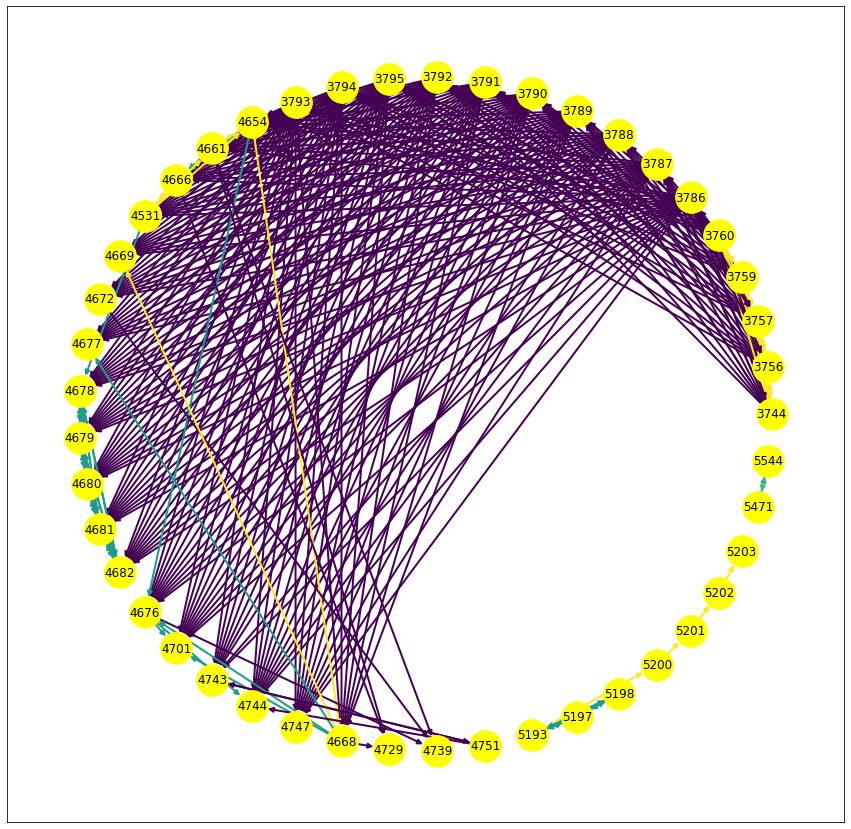

In [7]:
import matplotlib.pyplot as plt
G1 = nx.DiGraph()
badguys_color = []
for i,j,dt in G.edges(data = True):
    if i in badguys and j in badguys:
        G1.add_node(i)
        G1.add_node(j)
        G1.add_edge(i,j,weight = dt['weight'])
plt.figure(figsize=(15, 15))
edges,weights = zip(*nx.get_edge_attributes(G1,'weight').items())
nx.draw_networkx(G1,with_labels = True,pos = nx.circular_layout(G1), 
            edge_color = weights,
            width=2.0,node_color = "yellow", node_size= 1000)
plt.rcParams['axes.facecolor']='white'
plt.savefig("drawings/output.png")



In [9]:
f = motifs(g,k=3, return_maps=True)
print(f[0])
print(f[1])
graphlets_c = [[0]*g.num_vertices() for i in range(len(f[0]))]
for i,subg in enumerate(f[2]):
    for l in subg:
        for n in l.get_array():
            graphlets_c[i][int(n)]+=1

count = 0
for arrs in graphlets_c:
    nodes_g = [int(i) for i in g.vertices() if arrs[int(i)]!=0]
    arrs = [i for i in arrs if i != 0]
    plt.bar(nodes_g,arrs)
    plt.savefig(str(count)+".png")
    plt.close()
    count+=1
    break


KeyboardInterrupt: 